#### Advanced Statistics for Data Science (Spring 2022)
# Home Assignment 5
#### Topics:
- Contrasts
- Multiple TestinFalse-Discovery Rate
- Simple Regression

#### Due: 24/05/2022 by 18:30

#### Instructions:
- Write your name, Student ID, and date in the cell below. 
- Submit a copy of this notebook with code filled in the relevant places as the solution of coding excercises.
- For theoretic excercises, you can either write your solution in the notebook using $\LaTeX$ or submit additional notes.

<hr>
<hr>


**Name**: Saar Buchnik

**Student ID**: 305248361

**Date**: May 06th, 2022

$
\newcommand{\Id}{{\mathbf{I}}}  
\newcommand{\SSE}{\mathsf{SSE}}
\newcommand{\SSR}{\mathsf{SSR}}
\newcommand{\MSE}{\mathsf{MSE}}
\newcommand{\simiid}{\overset{iid}{\sim}}
\newcommand{\ex}{\mathbb E}
\newcommand{\var}{\mathrm{Var}}
\newcommand{\Cov}[2]{{\mathrm{Cov}  \left(#1, #2 \right)}}
\newcommand{\one}[1]{\mathbf 1 {\left\{#1\right\}}}
\newcommand{\SE}[1]{\mathrm{SE} \left[#1\right]}
\newcommand{\reals}{\mathbb R}
\newcommand{\Ncal}{\mathcal N}
\newcommand{\abs}[1]{\ensuremath{\left\vert#1\right\vert}}
\newcommand{\rank}{\operatorname{rank}}
\newcommand{\tr}{\operatorname{Tr}}
\newcommand{\diag}{\operatorname{diag}}
\newcommand{\sign}{\operatorname{sign}}
$


<hr>
<hr>

## Problem 1 (Multiple testing in Practice)
#### Continuation of Problem 4 from HW4

In HW4, Problem 4 you used ANOVA to measure the effect of the winary (``winary``) on the quality (``points``) of wines from veriaty (``veriaty``) ``Cabernet Sauvignon``. Using the same dataset (reduced to Israeli wines and a specific veriaty). You used all t-tests involving pairs of winaries and reported pairs found significant after a Bonfferoni's correction. In this question, you will use Binjamini-Hochberg's (BH) FDR controlling procedure as an alternative to Bonfferoni. 
 1. Using HW4, Problem 4, consider P-values from all t-tests of pairs of winaries. Sort the P-values from small to large and plot the smallest 10% of the sorted list of P-values on a stem or a scatter plot in which the x-axis indicate the P-value rank (left most point is rank = 1, i.e., the smallest) and the y-axis the P-value's value. 
 2. Assume that different tests are independet; apply BH to select a set of winary pairs in which one winary is significantly better than the others while aiming for 0.05 false pairs. How many pairs were reported? is it more or less pairs than you discovered using Bonfferoni correction in HW4, Problem 4?
 3. Repeat the last item without the independence assumption, i.e., use the harmonic sum correction.
 
The point: FDR controlling using BH is a more liberal (less conservative) approach to identify significnat discoveries in the sense that it allows us to report on more discoveries if we are willing to replace family-wise error rate control with an expected false-discovery proportion guarantee.  

## Problem 1 - Solution

----

#### Required Code From HW4

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import t as ttest
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv("winemag-data_first150k.csv")
data = data[data.variety == "Cabernet Sauvignon"]
data = data[data.country == "Israel"]
data = data[data.groupby('winery').winery.transform('count') > 1]

In [4]:
wineries, wineries_counts = np.unique(data.winery.values, return_counts=True)

wineries_counts = {
    winery: wineries_counts[idx]
    for idx, winery in enumerate(wineries)
}

y_ij = {
    winery: data[data.winery == winery].points.values
    for winery in wineries
}

y_i_bar = {
    winery: np.mean(y_ij[winery])
    for winery in wineries
}

y_bar = np.mean(data.points.values)

SS_within = np.sum(
    [
        np.sum(
            (y_ij[winery] - y_i_bar[winery])**2
        )
        for winery in wineries
    ]
)

SS_between = np.sum(
    [
        wineries_counts[winery] * (y_i_bar[winery] - y_bar)**2
        for winery in wineries
    ]
)

SS_tot = SS_within + SS_between

n = len(data.points.values)
k = len(wineries)

MS_between = SS_between / (k-1)
MS_within = SS_within / (n-k)

In [5]:
def two_sample_ttest(y0, y1, eps=10**-6):
    n0 = len(y0)
    n1 = len(y1)
    dof = n0+n1-2
    
    y0_bar = np.mean(y0)
    y1_bar = np.mean(y1)
    
    s_sqr = (1 / dof) * (np.sum((y0-y0_bar)**2) + np.sum((y1-y1_bar)**2))
    s = np.sqrt(s_sqr)
    
    if s==0:
        s = eps
    
    t_stat = (y1_bar - y0_bar) / (s * np.sqrt(1/n0 + 1/n1))
    
    return t_stat, dof

In [6]:
wineries_ttest_pvals = {}

for winery_0 in wineries:
    for winery_1 in wineries:
        if winery_0 == winery_1:
            continue 
        
        key = (winery_0, winery_1)
        
        if key in wineries_ttest_pvals or key[::-1] in wineries_ttest_pvals:
            continue
        
        y0 = y_ij[winery_0]
        y1 = y_ij[winery_1]
        
        t_stat, dof = two_sample_ttest(y0,y1)
        t_stat_pvalue = ttest.sf(abs(t_stat), dof)

        wineries_ttest_pvals[key] = t_stat_pvalue

### Part 1.1

In [7]:
# Sort The Pvalues dict
wineries_ttest_pvals = dict(sorted(wineries_ttest_pvals.items(), key=lambda item: item[1]))

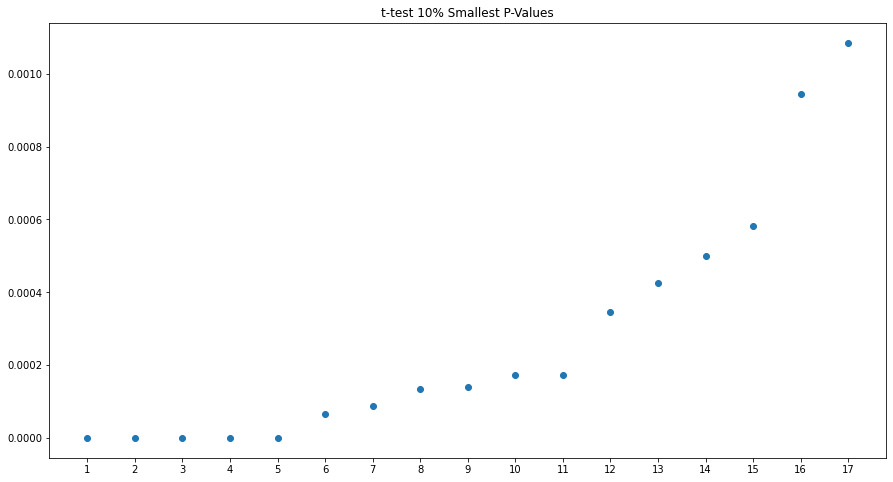

In [8]:
# Plot Smallest Pvalues
smallest_wineries_ttest_pvals = list(wineries_ttest_pvals.values())[:round(0.1 * len(wineries_ttest_pvals))]

xs = range(1, len(smallest_wineries_ttest_pvals)+1)

plt.rcParams['figure.figsize'] = [15, 8]
plt.scatter(xs, smallest_wineries_ttest_pvals)
plt.xticks(np.arange(min(xs), max(xs)+1, 1.0))
plt.title("t-test 10% Smallest P-Values")
plt.show()

### Part 1.2

In [9]:
pvals = np.asarray(list(wineries_ttest_pvals.values()))
alpha = 0.05
m = len(pvals)
inds = np.asarray(range(1, m+1))

fdr_li = inds * alpha / m
cutof_i = np.argmax(pvals>fdr_li)

print(f"Using FDR and assuming independent p-values,\n" 
      f"we detected {cutof_i}/{m} pairs in which one winary is significantly better than the other.\n"
      f"It is more pairs than we reported using Bonfferoni correction (9/{m} pairs)")

print("")
print("The Pairs:")
for idx, pair in enumerate(list(wineries_ttest_pvals.keys())[:cutof_i]):
    print(f"{idx+1} {pair} - p-value={wineries_ttest_pvals[pair]:.4f}")

Using FDR and assuming independent p-values,
we detected 40/171 pairs in which one winary is significantly better than the other.
It is more pairs than we reported using Bonfferoni correction (9/171 pairs)

The Pairs:
1 ('Katlav', 'Shiloh Winery') - p-value=0.0000
2 ('Shiloh Winery', 'Titora') - p-value=0.0000
3 ('Shiloh Winery', 'Tishbi Estate') - p-value=0.0000
4 ('Katlav', 'Tishbi Estate') - p-value=0.0000
5 ('Tishbi Estate', 'Titora') - p-value=0.0000
6 ('Bazelet HaGolan', 'Katlav') - p-value=0.0001
7 ('Kadesh Barnea', 'Shiloh Winery') - p-value=0.0001
8 ('Bazelet HaGolan', 'Recanati') - p-value=0.0001
9 ('Bazelet HaGolan', 'Kadesh Barnea') - p-value=0.0001
10 ('Bazelet HaGolan', 'Psagot') - p-value=0.0002
11 ('Psagot', 'Shiloh Winery') - p-value=0.0002
12 ('Kadesh Barnea', 'Yatir') - p-value=0.0003
13 ('Recanati', 'Shiloh Winery') - p-value=0.0004
14 ('Bazelet HaGolan', 'Titora') - p-value=0.0005
15 ('Katlav', 'Yatir') - p-value=0.0006
16 ('Recanati', 'Yatir') - p-value=0.0009
17 

### Part 1.3

In [10]:
cm = np.sum(1/inds)

ind_fdr_li = inds * alpha / m * (1/cm)
ind_fdr_cutof_i = np.argmax(pvals>ind_fdr_li)

print(f"Using FDR and assuming general dependency structure for the p-values,\n" 
      f"we detected {ind_fdr_cutof_i}/{m} pairs in which one winary is significantly better than the other.\n"
      f"It is more pairs than we reported using Bonfferoni correction (9/{m} pairs)")

print("")
print("The Pairs:")
for idx, pair in enumerate(list(wineries_ttest_pvals.keys())[:ind_fdr_cutof_i]):
    print(f"{idx+1} {pair} - p-value={wineries_ttest_pvals[pair]:.4f}")

Using FDR and assuming general dependency structure for the p-values,
we detected 15/171 pairs in which one winary is significantly better than the other.
It is more pairs than we reported using Bonfferoni correction (9/171 pairs)

The Pairs:
1 ('Katlav', 'Shiloh Winery') - p-value=0.0000
2 ('Shiloh Winery', 'Titora') - p-value=0.0000
3 ('Shiloh Winery', 'Tishbi Estate') - p-value=0.0000
4 ('Katlav', 'Tishbi Estate') - p-value=0.0000
5 ('Tishbi Estate', 'Titora') - p-value=0.0000
6 ('Bazelet HaGolan', 'Katlav') - p-value=0.0001
7 ('Kadesh Barnea', 'Shiloh Winery') - p-value=0.0001
8 ('Bazelet HaGolan', 'Recanati') - p-value=0.0001
9 ('Bazelet HaGolan', 'Kadesh Barnea') - p-value=0.0001
10 ('Bazelet HaGolan', 'Psagot') - p-value=0.0002
11 ('Psagot', 'Shiloh Winery') - p-value=0.0002
12 ('Kadesh Barnea', 'Yatir') - p-value=0.0003
13 ('Recanati', 'Shiloh Winery') - p-value=0.0004
14 ('Bazelet HaGolan', 'Titora') - p-value=0.0005
15 ('Katlav', 'Yatir') - p-value=0.0006


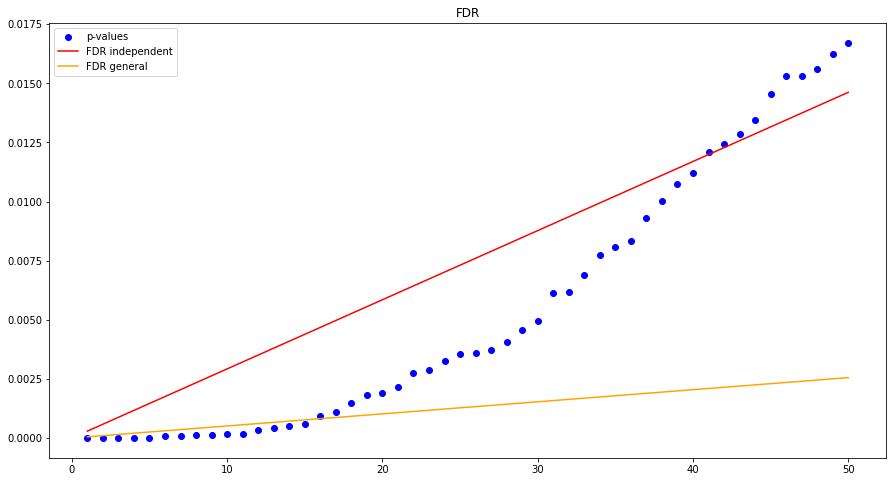

In [11]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.scatter(inds[:cutof_i+10], pvals[:cutof_i+10], label="p-values", color="blue")
plt.plot(inds[:cutof_i+10], fdr_li[:cutof_i+10], label="FDR independent", color="red")
plt.plot(inds[:cutof_i+10], ind_fdr_li[:cutof_i+10], label="FDR general", color="orange")
plt.title("FDR")
plt.legend()
plt.show()

## Problem 2 (contrasts)
#### Continuation of Problem 1

Using a single t-test, test the assumption that the average of the Golan area wineries: ``Bazelet HaGolan``, ``Gamla``, ``Golan Heights Winary`` have the same quality as the average of Judean Hills area wineries: ``Katlav``, ``Psagot``, ``Shiloh Winery``, ``Titora``, ``Yatir`` (the goal here is to construct a "contrast", hence you should take an arithmetic average of group averages. You should only consider the size of each individual group when evaluating the varaince of the contrast).

Note: you can ignore the ``province`` filed in the data becasue it contains inaccurate information. You should also ignore the fact that in reality, ``Gamla`` is produced by ``Golan Heights Winary``. 



## Problem 2 - Solution

----

In [19]:
s = np.sqrt(MS_within)

golan_wineries = ["Bazelet HaGolan", "Gamla", "Golan Heights Winery"]
judean_wineries = ["Katlav", "Psagot", "Shiloh Winery", "Titora", "Yatir"]

y_bars = [y_i_bar[winery] for winery in golan_wineries] + \
         [y_i_bar[winery] for winery in judean_wineries]
y_bars = np.asarray(y_bars)

lambdas = [1/len(golan_wineries)] * len(golan_wineries) + \
          [-1/len(judean_wineries)] * len(judean_wineries)
lambdas = np.asarray(lambdas)
    
n_factors = [len(y_ij[winery]) for winery in golan_wineries] + \
            [len(y_ij[winery]) for winery in judean_wineries]
n_factors = np.asarray(n_factors)

In [20]:
t_stat_numerator = np.sum(lambdas * y_bars)
t_stat_denominator = s * np.sqrt(np.sum(lambdas**2 / n_factors))
t_stat = t_stat_numerator / t_stat_denominator

dof = np.sum(n_factors) - len(lambdas)
t_stat_pvalue = ttest.sf(abs(t_stat), dof)

alpha = 0.05
reject = "reject" if t_stat_pvalue < alpha else "can't reject"
print(f"We {reject} the null hypothesis (Golan area wineries have the same quality as Judean Hills area wineries) "
      "at level {alpha}, with p-value {t_stat_pvalue:.4f}")

We can't reject the null hypothesis (Golan area wineries have the same quality as Judean Hills area wineries) at level {alpha}, with p-value {t_stat_pvalue:.4f}


In [ ]:
t_stat_numerator, t_stat_denominator

(176.52698412698413, 0.709939326284566)

## Problem 3 (Exact size of Bonferroni's test)
Suppose that we run multiple tests with independent data and obtain P-values $p_1,\ldots,p_n$. We wish to test the null hypothesis:
$$
H_0\,:\,\text{All tests are null}
$$
at the level $\alpha$ (e.g., $\alpha=0.05$). In class, we introduced Bonferroni's procedure which is equivalent to: Reject $H_0$ if $\min p_i \leq \alpha/n$. 
1. Show that the  size of the test in Bonferroni's procedure is at most $\alpha$, regardless if the hypotheses are independent or not. 
2. Assuming that the hypotheses are independent, find the exact size of the test in Bonferroni's procedure. 
3. For $\alpha=0.05$, evalaute the difference between $\alpha$ and the exact test's size for $n=2,...,50$. Discuss what you see. 



## Problem 3 - Solution

----

### Part 3.1

$
\mathbb{P} \left( reject H_0 | H_0 \right) 
=
\mathbb{P} \left( \min p_i \leq \frac{\alpha}{n} \right) 
=
\mathbb{P} \left( p_1 \leq \frac{\alpha}{n} \cup p_2 \leq \frac{\alpha}{n} \cup ... \cup p_n \leq \frac{\alpha}{n}\right)
\leq^{(*)}
\sum_{i=1}^{n} \mathbb{P} \left( p_i \leq \frac{\alpha}{n} \right) 
=^{(**)}
\sum_{i=1}^{n} \frac{\alpha}{n}
=
n \frac{\alpha}{n}
= 
\alpha
$

* $(*)$ - Union Bound
* $(**)$ - The definition of a p-value

### Part 3.2

$
\mathbb{P} \left( reject H_0 | H_0 \right) 
=
\mathbb{P} \left( \min p_i \leq \frac{\alpha}{n} \right) 
=\\
\mathbb{P} \left( p_1 \leq \frac{\alpha}{n} \cup p_2 \leq \frac{\alpha}{n} \cup ... \cup p_n \leq \frac{\alpha}{n}\right)
=\\
1 - \mathbb{P} \left( p_1 > \frac{\alpha}{n} \cap p_2 > \frac{\alpha}{n} \cap ... \cap p_n > \frac{\alpha}{n}\right)
=\\
1 - \mathbb{P} \left( p_1 > \frac{\alpha}{n} \right) \mathbb{P} \left( p_2 > \frac{\alpha}{n} \right) ... \mathbb{P} \left( p_n > \frac{\alpha}{n} \right)
= \\
1 - \prod_{i=1}^{n} \mathbb{P} \left( p_i > \frac{\alpha}{n} \right)
= \\
1 - \prod_{i=1}^{n} \left( 1 - \mathbb{P} \left( p_i \leq \frac{\alpha}{n} \right) \right)
=\\
1 - \prod_{i=1}^{n} \left( 1 - \frac{\alpha}{n} \right)
=\\
1 - \left( 1 - \frac{\alpha}{n} \right)^n
$

### Part 3.3

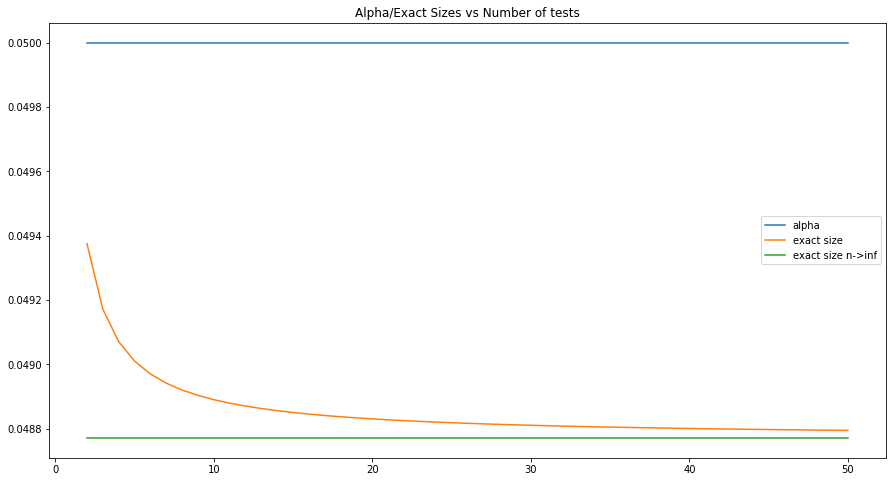

In [13]:
alpha = 0.05
ns = np.asarray(range(2,51))

exact_sizes = 1 - (1 - alpha / ns) ** ns
diffs = alpha - exact_sizes

exact_size_lim = 1 - np.exp(-alpha)

plt.rcParams['figure.figsize'] = [15, 8]
plt.plot(ns, [alpha] * len(ns), label="alpha")
plt.plot(ns, exact_sizes, label="exact size")
plt.plot(ns, [exact_size_lim] * len(ns), label="exact size n->inf")
plt.title("Alpha/Exact Sizes vs Number of tests")
plt.legend()
plt.show()

- We see that the difference increases with the number of tests.
- It means that Bonferoni gets more "conservative" as the number of tests increases (we will reject less hypotheses).
- We note that the differecne converges to the limit:  
  $\lim_{n\to\infty} 1 - \left( 1 - \frac{\alpha}{n} \right)^n = 1 - e^{-\alpha}$
- Thus, even for large number of tests, the difference between $\alpha$ and the exact test size will not diverge.

## Problem 4 (Prediction in Simple Regression)
Consider the linear model:
$$
    y_i = \beta_0 + \beta_1 x_i + \epsilon_i,\qquad \epsilon_i \simiid \Ncal(0,\sigma^2)
$$
$$
    Z = \begin{pmatrix}
    1 & x_1 \\
    \vdots & \vdots \\
    1 & x_n
    \end{pmatrix},\quad \beta=\begin{pmatrix}
    \beta_0 \\
    \beta_1
    \end{pmatrix},\qquad \hat{\beta}=(Z^\top Z)^{-1} Z^\top y
$$
Suppose we get a new data point $x_{n+1}$ and want to predict $y_{n+1}$. We want an interval in which this prediction will likely to land. In class, we used that 
$$
\var[\hat{\beta}_0 + \hat{\beta}_1 x] = \frac{\sigma^2}{n} \left( 1 + \frac{(x-\bar{x})^2}{S_{XX }}\right)
$$
to obtain a confidence interval for $\beta_0 + \beta_1 x$, and a confidence band for all $x \in \reals$. In this question, you will use a similar reasoning to get a confidence interval (and bands) for $y_{n+1}$.
1. Find the varaince of $y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1})$ in terms of $\sigma^2$ and $x_1,\ldots,x_n$ and $x_{n+1}$ (you can use $\bar{x}$ and $S_{XX}$ or any other well-defined function of $x_1,\ldots,x_n$). Explain intuitively why it makes sense that this variance is larger than the variance of  $\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}$. 
2. Find a $1-\alpha$ confidence interval for $y_{n+1}$. Is this interval wider or narrower than that of $\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}$? For what value of $x_{n+1}$ this interval is the narrowest?
3. Suppose that we take the average of two responses $y$'s at the same $x_{n+1}$, say 
$$
y_{n+1} =  \frac{y_{n+1}^{(1)} + y_{n+1}^{(2)}}{2}, 
$$
where
$$
y_{n+1}^{(1)} = \beta_0 + \beta_1 x_{n+1} + \epsilon_{n+1}^{(1)}
$$
and 
$$
y_{n+1}^{(2)} = \beta_0 + \beta_1 x_{n+1} + \epsilon_{n+1}^{(2)},
$$
where $\epsilon_{n+1}^{(1)}$ and $\epsilon_{n+1}^{(2)}$ are independent. Find a confidence interval for $y_{n+1}$. Is it wider or narrower than the interval in (2) ?

Note: The confidence interval you derived in 2 is somewhat risky to use becasue it makes the strong assumption that $\epsilon_{n+1}$ is normal. This is compared to, say, confidence intrvals for $\hat{\beta}_0$ and $\hat{\beta}_1$ which rely on averages over all observations $y_1,\ldots,y_n$ so we can use the Central Limit Theorem to argue for normality. Thigs gets better both in terms of varaince and normality assumption when you can take multiple measurements at the same $x_{n+1}$ and average those. 


## Problem 4 - Solution

----

### Part 4.1

We note that:  
* By definition of the linear model:  
  $y_{n+1} = \beta_0 + \beta_1 x_{n+1} + \epsilon_{n+1}$  
  Where:  
  $\epsilon_{n+1} \sim \Ncal(0,\sigma^2)$  
  As $\epsilon_{n+1}$ is the only RV, $\beta_0,\beta_1,x_{n+1}$ are constants, we get that:  
  (1) $y_{n+1} \sim \Ncal(0,\sigma^2)$  

* 
$
cov(y_{n+1}, \hat{\beta}_0 + \hat{\beta}_1 x_{n+1}) 
=
cov(\beta_0 + \beta_1 x_{n+1} + \epsilon_{n+1}, \hat{\beta}_0 + \hat{\beta}_1 x_{n+1})
=^{*}
cov(\epsilon_{n+1}, \hat{\beta}_0 + \hat{\beta}_1 x_{n+1})
=^{**}
0
$  
(\*) $\beta_0,\beta_1,x_{n+1}$ are constants  
(\*\*) $\epsilon_{n+1}$ is independent of $\hat{\beta}_0, \hat{\beta}_1$ (as they are only dependent on $\epsilon_{1..n}$)  
Thus:  
(2) $cov(y_{n+1}, \hat{\beta}_0 + \hat{\beta}_1 x_{n+1}) = 0$

Now we can calculate:  
$
\var(y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}))
=
\var(y_{n+1}) + \var(\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}) - 2 cov(y_{n+1}, \hat{\beta}_0 + \hat{\beta}_1 x_{n+1})
$

From (1) and (2):  
$
\var(y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}))
=
\sigma^2 + \var(\hat{\beta}_0 + \hat{\beta}_1 x_{n+1})
=
\sigma^2 + \frac{\sigma^2}{n} \left( 1 + \frac{(x_{n+1}-\bar{x})^2}{S_{XX }}\right)
=
\sigma^2 \left( 1 + \frac{1}{n} + \frac{(x_{n+1}-\bar{x})^2}{S_{XX }}\right)
$

We can easily see that this variance is larger than the variance of  $\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}$ (we added a $1+..$ in the brackets).   
It makes sense, we added another RV ($y_{n+1}$, or to be explicit - $\epsilon_{n+1}$) which is not dependent on $\hat{\beta}_0, \hat{\beta}_1$, thus the variance will get bigger.

### Part 4.2

We have:  
$\frac{y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1})}{s \sqrt{\var(y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}))}} \sim t_{n-2}$

We can plug in the variance we calculated:  
$\frac{y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1})}{s \sqrt{\sigma^2 \left( 1 + \frac{1}{n} + \frac{(x_{n+1}-\bar{x})^2}{S_{XX }}\right)}} \sim t_{n-2}$

And build the confidence interval:  
$
1 - \alpha 
= \\
\mathbb{P} 
    \left( 
    -t_{n-2}^{1-\frac{\alpha}{2}}
    \leq
    \frac{y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1})}{s \sqrt{\sigma^2 \left( 1 + \frac{1}{n} + \frac{(x_{n+1}-\bar{x})^2}{S_{XX }}\right)}}
    \leq
    t_{n-2}^{1-\frac{\alpha}{2}}
\right)
=\\
\mathbb{P} 
    \left( 
    (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}) - t_{n-2}^{1-\frac{\alpha}{2}} \cdot s \sqrt{\sigma^2 \left( 1 + \frac{1}{n} + \frac{(x_{n+1}-\bar{x})^2}{S_{XX }}\right)}
    \leq
    y_{n+1}
    \leq
    (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}) + t_{n-2}^{1-\frac{\alpha}{2}} \cdot s \sqrt{\sigma^2 \left( 1 + \frac{1}{n} + \frac{(x_{n+1}-\bar{x})^2}{S_{XX }}\right)}
\right)
$

So, with probability $1 - \alpha$:  
$
y_{n+1}
\in 
(\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}) \pm t_{n-2}^{1-\frac{\alpha}{2}} \cdot s \sqrt{\sigma^2 \left( 1 + \frac{1}{n} + \frac{(x_{n+1}-\bar{x})^2}{S_{XX }}\right)}
$

----
* This interval is wider than the interval for $\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}$.  
  We can see that because there is an extra "$1+$" under the root.
* This interval is the narrowest for $x_{n+1} = \bar{x}$.  
  This will zero out the only term in the interval that depends on $x_{n+1}$.

### Part 4.3

We wil first calculate the variance of $y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1})$:

$
\var(y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}))
=\\
\var(\frac{y_{n+1}^{(1)} + y_{n+1}^{(2)}}{2} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}))
=\\
\var(\frac{\beta_0 + \beta_1 x_{n+1} + \epsilon_{n+1}^{(1)}}{2} + \frac{\beta_0 + \beta_1 x_{n+1} + \epsilon_{n+1}^{(2)}}{2} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}))
=\\
\var((\beta_0 + \beta_1 x_{n+1}) + \frac{1}{2}\epsilon_{n+1}^{(1)} + \frac{1}{2}\epsilon_{n+1}^{(2)} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}))
=^{(*)}\\
\var(\frac{1}{2}\epsilon_{n+1}^{(1)} + \frac{1}{2}\epsilon_{n+1}^{(2)} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}))
= ^{(**)}\\
\var(\frac{1}{2}\epsilon_{n+1}^{(1)}) + \var(\frac{1}{2}\epsilon_{n+1}^{(2)}) + \var(\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}))
=\\
\frac{1}{4} \var(\epsilon_{n+1}^{(1)}) + \frac{1}{4} \var(\epsilon_{n+1}^{(2)}) + \var(\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}))
=\\
\frac{1}{2} \sigma^2 + \frac{\sigma^2}{n} \left( 1 + \frac{(x_{n+1}-\bar{x})^2}{S_{XX }}\right)
=\\
\sigma^2 \left( \frac{1}{2} + \frac{1}{n} + \frac{(x_{n+1}-\bar{x})^2}{S_{XX }}\right)
$

* (\*) $\beta_0,\beta_1,x_{n+1}$ are constants  
* (\*\*) $\epsilon_{n+1}^{(1)}$, $\epsilon_{n+1}^{(2)}$ are independent of each other, and independent of $\hat{\beta}_0, \hat{\beta}_1$ (as they are only dependent on $\epsilon_{1..n}$).

So to sum up so far, we got:  
$
\var(y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}))
=
\sigma^2 \left( \frac{1}{2} + \frac{1}{n} + \frac{(x_{n+1}-\bar{x})^2}{S_{XX }}\right)
$

Now, using the same logic from the previous section, we have:  
$\frac{y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1})}{s \sqrt{\var(y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}))}} \sim t_{n-2}$

We can plug in the variance we calculated:  
$\frac{y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1})}{s \sqrt{\sigma^2 \left( \frac{1}{2} + \frac{1}{n} + \frac{(x_{n+1}-\bar{x})^2}{S_{XX }}\right)}} \sim t_{n-2}$

And build the confidence interval:  
$
1 - \alpha 
= \\
\mathbb{P} 
    \left( 
    -t_{n-2}^{1-\frac{\alpha}{2}}
    \leq
    \frac{y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1})}{s \sqrt{\sigma^2 \left( \frac{1}{2} + \frac{1}{n} + \frac{(x_{n+1}-\bar{x})^2}{S_{XX }}\right)}}
    \leq
    t_{n-2}^{1-\frac{\alpha}{2}}
\right)
=\\
\mathbb{P} 
    \left( 
    (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}) - t_{n-2}^{1-\frac{\alpha}{2}} \cdot s \sqrt{\sigma^2 \left( \frac{1}{2} + \frac{1}{n} + \frac{(x_{n+1}-\bar{x})^2}{S_{XX }}\right)}
    \leq
    y_{n+1}
    \leq
    (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}) + t_{n-2}^{1-\frac{\alpha}{2}} \cdot s \sqrt{\sigma^2 \left( \frac{1}{2} + \frac{1}{n} + \frac{(x_{n+1}-\bar{x})^2}{S_{XX }}\right)}
\right)
$

So, with probability $1 - \alpha$:  
$
y_{n+1}
\in 
(\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}) \pm t_{n-2}^{1-\frac{\alpha}{2}} \cdot s \sqrt{\sigma^2 \left( \frac{1}{2} + \frac{1}{n} + \frac{(x_{n+1}-\bar{x})^2}{S_{XX }}\right)}
$

-----
* This interval is narrower than the interval in (2) ($0.5 < 1$).
* In fact, as we seen in class, the more samples we will take the narrower the interval will get.
    * If we take the limit of $\infty$ samples, we will get the same confidence interval as the one of $\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}$.